# Skydog 周报

本Notebook分析Skydog的投资活动中每周需要关注的重要数据。
主要关注的是风险的监控。

In [24]:
#all imports
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from scipy import stats
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

In [25]:
print('This report was refreshed at %s'%(dt.datetime.now()))

This report was refreshed at 2022-01-10 10:44:05.738603


In [26]:
#init
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})
pd.options.display.float_format = '{:,.2f}'.format

df_holding=pd.read_csv('../data/skydog/portfolio_latest_holdings_vw.csv')
df_price=pd.read_csv('../data/skydog/latest_price.csv')
df_trans=pd.read_csv('../data/skydog/security_transactions.csv')

## 过去一周操作

In [27]:
df_trans.loc[(df_trans['trade_type']=='Trade') & (pd.to_datetime(df_trans['trade_date'])>=pd.to_datetime(dt.date.today()-dt.timedelta(weeks=1))) ,['trade_date','trade_type','asset_id','quantity','price','commission']].sort_values(by='trade_date')

,trade_date,trade_type,asset_id,quantity,price,commission


## 投资组合资产配置

以下是Skydog的资产配置情况。

### 大类资产配置

In [28]:
#Long asset allocations
df_asset_alloc=df_holding.groupby('sub_type').agg('sum')
df_long_alloc=df_asset_alloc[df_asset_alloc['market_val_usd']>0]
total_long=df_long_alloc['market_val_usd'].sum()
df_long_alloc['pct']=100*df_long_alloc['market_val_usd']/total_long
df_long_alloc=df_long_alloc[['market_val_usd','pct']].sort_values('market_val_usd',ascending=False)
df_long_alloc.index.name='Asset Type'
#df_long_alloc.plot.pie(y='market_val_usd',autopct="%.1f%%")
df_long_alloc.loc['Total Long']=df_long_alloc.sum()
df_long_alloc.style.format({"market_val_usd":"${:,.0f}",
                          "pct":"{:,.1f}%",
                          })

,market_val_usd,pct
Asset Type,,
Shares,"$15,907,785",56.0%
Cash,"$8,501,341",29.9%
FCN,"$2,884,519",10.2%
Fund,"$978,816",3.4%
Bond,"$116,241",0.4%
Total Long,"$28,388,702",100.0%


In [29]:
#Short asset allocation
df_short_alloc=df_asset_alloc[df_asset_alloc['market_val_usd']<0]
total_short=df_short_alloc['market_val_usd'].sum()
df_short_alloc['pct']=100*df_short_alloc['market_val_usd']/total_short
df_short_alloc=df_short_alloc[['market_val_usd','pct']].sort_values('market_val_usd',ascending=False)
df_short_alloc.index.name='Asset Type'
df_short_alloc.loc['Total Short']=df_short_alloc.sum()
df_short_alloc.style.format({"market_val_usd":"${:,.0f}",
                          "pct":"{:,.1f}%",
                          })

,market_val_usd,pct
Asset Type,,
Total Short,$0,0.0%


### 市场配置

In [30]:
#Market allocations
df_market_alloc=df_holding.groupby('market').agg('sum')
total_long=df_market_alloc['market_val_usd'].sum()
df_market_alloc['pct']=100*df_market_alloc['market_val_usd']/total_long
df_market_alloc=df_market_alloc[['market_val_usd','pct']].sort_values('market_val_usd',ascending=False)
df_market_alloc.index.name='Market'
#df_long_alloc.plot.pie(y='market_val_usd',autopct="%.1f%%")
df_market_alloc.loc['Total']=df_market_alloc.sum()
df_market_alloc.style.format({"market_val_usd":"${:,.0f}",
                          "pct":"{:,.1f}%",
                          })

,market_val_usd,pct
Market,,
中国,"$13,567,628",47.8%
CASH,"$8,501,341",29.9%
美国,"$3,987,053",14.0%
新兴市场,"$1,107,038",3.9%
全球,"$338,708",1.2%
其它发达国家,"$319,507",1.1%
澳大利亚,"$316,709",1.1%
其他,"$230,718",0.8%
其他发达国家,"$20,001",0.1%


## 投资组合持仓


### 十大风险暴露

以下是Skydog基金和个Terry个人账户合计的风险暴露最大的10家公司。
备注：
1. 计算风险暴露的时候，现金的风险=0
2. 计算市值占比的时候，总资产包含了现金

In [31]:


df_company=df_holding.groupby('company').agg('sum').sort_values(by='risk_exposure_usd',ascending=False)
total_risk=df_company.risk_exposure_usd.sum()
total_market_value=df_company.market_val_usd.sum()
df_company['risk_pct']=(100*df_company.risk_exposure_usd/total_risk)
df_company['market_value_pct']=(100*df_company.market_val_usd/total_market_value)
df_risk_exp=df_company[['risk_exposure_usd','risk_pct','market_val_usd','market_value_pct']].head(10)
df_risk_exp.loc['Total']=df_risk_exp.sum()
df_risk_exp.style.format({"market_val_usd":"${:,.0f}",
                          "risk_exposure_usd":"${:,.0f}",
                          "risk_pct":"{:,.1f}%",
                          "market_value_pct":"{:,.1f}%",

                        })

,risk_exposure_usd,risk_pct,market_val_usd,market_value_pct
company,,,,
腾讯,"$3,643,613",23.2%,"$3,643,613",12.9%
阿里巴巴,"$3,212,815",20.5%,"$3,212,815",11.4%
Facebook,"$1,062,060",6.8%,"$2,061,728",7.3%
小米,"$976,130",6.2%,"$976,130",3.5%
腾讯音乐,"$930,406",5.9%,"$930,406",3.3%
百度,"$616,132",3.9%,"$616,132",2.2%
KWEB,"$433,680",2.8%,"$433,680",1.5%
美团,"$398,867",2.5%,"$398,867",1.4%
EWZ,"$339,212",2.2%,"$339,212",1.2%


### FCN

当前持有的FCN如下：

In [32]:
df_fcn=df_holding[df_holding['sub_type']=='FCN']
df_fcn=df_fcn[['desc','market_val_usd']]
df_fcn.style.format({"market_val_usd":"${:,.0f}",
                          

                        })

,desc,market_val_usd
76,NOM FCN INTC 48.8070 QCOM 132.7500 22 FEB 2022,"$382,280"
77,NOM FCN 700 HK 493.6500 9988 HK 185.0400 19 JAN 2022,"$277,659"
78,UBS FCN 6862 HK 34.5525 10 Jan 2022,"$224,580"
79,JPM FCN FB 276.3150 17 MAR 2022,"$1,000,000"
80,C FCN QQQ 343.0946 SPY 410.0232 26 APR 2022,"$1,000,000"


### 一周市值减少 Top 10

In [33]:
#get all holding data
df_ticker=df_holding.groupby('ticker').sum().merge(df_price.set_index('ticker'),how='left',left_index=True,right_index=True)
df_ticker = df_ticker.loc[:, ~df_ticker.columns.str.contains('^Unnamed')] # remove unanmed columns
df_ticker['market_val_chg_1w']=df_ticker['market_val_usd']*(1-1/(1+df_ticker['1w_chg_pct']/100))

In [34]:
df_ticker.sort_values(by='market_val_chg_1w').head(10)[['close','quantity','market_val_usd','market_val_chg_1w','1w_chg_pct']]

,close,quantity,market_val_usd,market_val_chg_1w,1w_chg_pct
ticker,,,,,
CASH-USD,0.00,"4,870,186.93","4,870,186.93","-1,806,192.53",-27.05
0700.HK,443.00,"64,159.00","3,643,612.69","-123,372.89",-3.28
3690.HK,204.00,"15,252.00","398,866.77","-46,143.42",-10.37
1877.HK,41.65,"19,600.00","104,650.66","-43,593.97",-29.41
1810.HK,18.26,"417,000.00","976,130.15","-33,143.46",-3.28
BGNE,229.52,689.00,"158,139.28","-28,531.48",-15.28
2269.HK,80.75,"15,400.00","159,416.82","-23,295.59",-12.75
6160.HK,136.30,"6,700.00","117,068.91","-21,214.98",-15.34
9926.HK,28.15,"29,000.00","104,651.94","-21,190.62",-16.84


### 一周市值增加 Top 10

In [35]:
df_ticker.sort_values(by='market_val_chg_1w',ascending=False).head(10)[['close','quantity','market_val_usd','market_val_chg_1w','1w_chg_pct']]

,close,quantity,market_val_usd,market_val_chg_1w,1w_chg_pct
ticker,,,,,
9988.HK,128.80,"116,670.00","1,926,397.76","145,078.16",8.14
BABA,129.81,"9,910.00","1,286,417.08","109,208.17",9.28
1177.HK,5.86,"305,000.00","229,122.83","15,248.80",7.13
BIDU,153.33,"2,396.00","367,378.68","10,877.86",3.05
9888.HK,149.00,"13,023.00","248,752.93","6,677.93",2.76
2202.HK,20.45,"15,000.00","39,323.80","4,480.41",12.86
DAO,12.60,"26,501.00","333,912.61","3,180.14",0.96
IH,2.98,"11,750.00","35,015.00","2,115.00",6.43
LAIX,0.58,"64,324.00","37,539.49","1,294.46",3.57


### 一周跌幅 Top 10

In [36]:

df_ticker.sort_values(by='1w_chg_pct').head(10)[['quantity','market_val_usd','close','1d_chg_pct','1w_chg_pct','market_val_chg_1w','1m_chg_pct','1y_chg_pct']]

,quantity,market_val_usd,close,1d_chg_pct,1w_chg_pct,market_val_chg_1w,1m_chg_pct,1y_chg_pct
ticker,,,,,,,,
1877.HK,"19,600.00","104,650.66",41.65,-1.77,-29.41,"-43,593.97",-2.12,-28.19
CASH-USD,"4,870,186.93","4,870,186.93",0.00,-16.29,-27.05,"-1,806,192.53",-37.51,"1,610.66"
9926.HK,"29,000.00","104,651.94",28.15,5.23,-16.84,"-21,190.62",-33.92,-36.67
1801.HK,"17,500.00","90,185.14",40.20,1.52,-16.60,"-17,947.29",-38.72,-51.24
MRNA,100.00,"21,386.00",213.86,-1.02,-15.80,"-4,012.00",-24.54,89.68
6160.HK,"6,700.00","117,068.91",136.30,2.87,-15.34,"-21,214.98",-27.54,-11.44
BGNE,689.00,"158,139.28",229.52,1.85,-15.28,"-28,531.48",-27.14,-17.81
GOTU,"10,320.00","17,028.00",1.65,0.00,-14.95,"-2,992.80",-31.82,-96.60
2269.HK,"15,400.00","159,416.82",80.75,3.06,-12.75,"-23,295.59",-20.68,-15.00


### 一周涨幅 Top 10

In [37]:
df_ticker.dropna().sort_values(by='1w_chg_pct',ascending=False ).head(10)[['quantity','market_val_usd','close','1d_chg_pct','1w_chg_pct','market_val_chg_1w','1m_chg_pct','1y_chg_pct']]

,quantity,market_val_usd,close,1d_chg_pct,1w_chg_pct,market_val_chg_1w,1m_chg_pct,1y_chg_pct
ticker,,,,,,,,
2202.HK,"15,000.00","39,323.80",20.45,7.18,12.86,"4,480.41",7.86,-19.05
BABA,"9,910.00","1,286,417.08",129.81,2.51,9.28,"109,208.17",3.78,-45.04
9988.HK,"116,670.00","1,926,397.76",128.80,6.45,8.14,"145,078.16",6.80,-42.55
1177.HK,"305,000.00","229,122.83",5.86,0.34,7.13,"15,248.80",5.97,-22.16
WE,"1,000.00","9,210.00",9.21,0.77,7.09,610.00,5.50,-21.82
IH,"11,750.00","35,015.00",2.98,-1.16,6.43,"2,115.00",-23.98,-85.23
LAIX,"64,324.00","37,539.49",0.58,-1.69,3.57,"1,294.46",-27.50,-60.27
BIDU,"2,396.00","367,378.68",153.33,1.71,3.05,"10,877.86",2.95,-36.18
9888.HK,"13,023.00","248,752.93",149.00,4.93,2.76,"6,677.93",2.76,-40.87


## 资产相关度监测

### 核心持仓之间的相关度
以下是当前重仓的标的之间的相关度：

In [38]:
ticker_list=['0700.HK','BABA','FB','1810.HK','TME']
df_price=pd.DataFrame()

for ticker in ticker_list:
    data=yf.download(ticker,progress=False,auto_adjust=True)
    df_price[ticker]=data['Close'].dropna()
    df_return=df_price.pct_change().dropna()
    

In [39]:
def cal_rolling_cov(s1,s2,period):
    start_date=s1.index[0]
    cov=dict()
    while start_date<s1.index.max()-dt.timedelta(days=period):
        end_date=start_date+dt.timedelta(days=period)
        a1=s1[start_date:end_date]
        a2=s2[start_date:end_date]
        cov[end_date]=stats.pearsonr(a1, a2)[0]
        start_date=start_date+dt.timedelta(days=1)
    cov=pd.Series(cov)
    cov.name=s1.name+'-'+s2.name

    return pd.Series(cov)


In [40]:
# Calculate correlations
resample='1W'
days=90

df_price_rs=df_price.resample(resample).last()
df_price_rs
df_return=df_price_rs.pct_change().dropna()


df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        if ticker2+'_'+ticker1 in df_cov.columns:
            df_cov[ticker1+'_'+ticker2]=df_cov[ticker2+'_'+ticker1]
        else:
            df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],days)


In [41]:
pd.options.display.float_format = '{:,.2f}'.format
df_cov_current=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_current.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]
print('%i Days Trailling Correlation based on %s return'%(days,resample))
df_cov_current


90 Days Trailling Correlation based on 1W return


,0700.HK,BABA,FB,1810.HK,TME
0700.HK,1.00,0.33,-0.04,0.81,0.47
BABA,0.33,1.00,0.40,0.15,0.90
FB,-0.04,0.40,1.00,-0.16,0.44
1810.HK,0.81,0.15,-0.16,1.00,0.37
TME,0.47,0.90,0.44,0.37,1.00


Text(0.5, 1.0, 'Rolling 90 Days Correlation based on 1W Return')

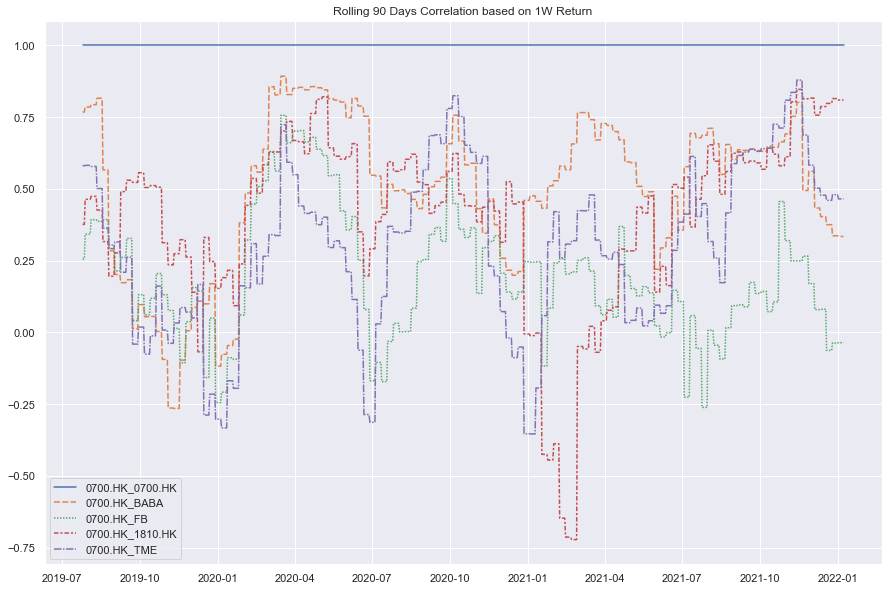

In [42]:
focus='0700.HK'
col=[]
for ticker in ticker_list:
    col.append(focus+"_"+ticker)
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=days*10):])
plt.title('Rolling %i Days Correlation based on %s Return'%(days,resample))

### 大类资产相关度监测

In [43]:
ticker_list=['QQQ','2822.HK','GLD','TLT','BTC-USD','GSG']
df_price=pd.DataFrame()

for ticker in ticker_list:
    data=yf.download(ticker,auto_adjust=True,progress=False)
    df_price[ticker]=data['Close'].dropna()
    df_return=df_price.pct_change().dropna()
    

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/connection.py", line 416, in connect
    self.sock = ssl_wrap_socket(
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 449, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 493, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  F

In [ ]:
# Calculate correlations
resample='1W'
days=90

df_price_rs=df_price.resample(resample).last()
df_price_rs
df_return=df_price_rs.pct_change().dropna()


df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        if ticker2+'_'+ticker1 in df_cov.columns:
            df_cov[ticker1+'_'+ticker2]=df_cov[ticker2+'_'+ticker1]
        else:
            df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],days)


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
df_cov_current=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_current.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]
print('%i Days Trailling Correlation based on %s return'%(days,resample))
df_cov_current


90 Days Trailling Correlation based on 1W return


,QQQ,2822.HK,GLD,TLT,BTC-USD,GSG
QQQ,1.00,0.18,0.22,-0.30,0.09,0.59
2822.HK,0.18,1.00,0.05,-0.52,0.08,0.45
GLD,0.22,0.05,1.00,-0.24,0.29,0.38
TLT,-0.30,-0.52,-0.24,1.00,0.04,-0.71
BTC-USD,0.09,0.08,0.29,0.04,1.00,0.42
GSG,0.59,0.45,0.38,-0.71,0.42,1.00


Text(0.5, 1.0, 'Rolling 90 Days Correlation based on 1W Return')

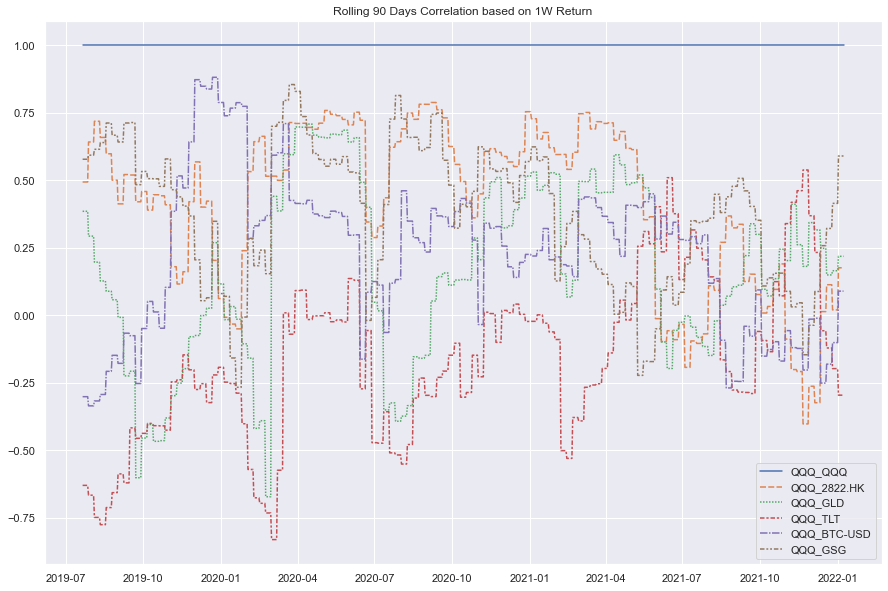

In [ ]:
focus='QQQ'
col=[]
for ticker in ticker_list:
    col.append(focus+"_"+ticker)
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=days*10):])
plt.title('Rolling %i Days Correlation based on %s Return'%(days,resample))